<a href="https://colab.research.google.com/github/jan-kreischer/UZH_ML4NLP/blob/main/Project-01/ex01_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 01 - Part 02

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)



In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## 1. Data Acquisition
In this assignment we are not going to do all the data cleaning and preprocessing again.  
We are just loading the saved dataset from the first exercise.

In [ ]:
!pip install demoji

     |████████████████████████████████| 42 kB 679 kB/s 


In [ ]:
!pip install googletrans==4.0.0rc1

     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 1.2 MB 27.7 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=ab51c0e4dc37633575e4f28eb4253156e8a7e8ea46131278007b70852f53d617
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans


### Imports

In [ ]:
from io import StringIO
import requests
import matplotlib.pyplot as plt

import warnings


import csv
import re
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 200)  
pd.set_option('display.max_columns', 200)   
pd.set_option('display.width', 4000) 


import demoji

from sklearn.utils import resample

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from googletrans import Translator
translator = Translator()

In [ ]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

In [ ]:
#translated_data = pd.read_pickle('sample_data/augmented_data.pkl')

### Constants

In [ ]:
TARGET_COLUMN = 'label'
TWEET_COLUMN = 'tweet'
SAMPLE_THRESHOLD = 20

### 1. Data Acquisition

In [ ]:
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [ ]:
training_data = load_dataset(url_train_dev)
test_data = load_dataset(url_test)

In [ ]:
dataset = pd.concat([training_data, test_data], axis=0) # Merge into one dataset for the pre-processing

In [ ]:
print("The length of the combined dataset is {0} training samples + {1} test samples = {2} samples".format(len(training_data), len(test_data), len(dataset)))

The length of the combined dataset is 52675 training samples + 13279 test samples = 65954 samples


In [ ]:
dataset = dataset.sample(frac=1).reset_index(drop=True) # Randomly shuffle the data

In [ ]:
dataset.head(10)

,tweet,label
0,Anyone goin to the rope swing?,en
1,No fue fácil pero valió la pena.,es
2,@jochortega es plaga el lala jajajaja,es
3,特進の校舎のトイレはウォシュレットがついていて羨ましい,ja
4,"두 눈을 감은 이유가, 누구때문도 아니기를...",ko
5,"Today stats: One follower, No unfollowers via ...",en
6,Phone-hacking case shows openness is best poli...,en
7,@BlEBERSKING haha baby💕,und
8,Brezilya artik sana aciyorum. :(,tr
9,@EmmaPereyraaa jajajaja ;))))),und


### 2. Data Exploration

In [ ]:
def data_exploration(df):
  n_labels = len(np.unique(df["label"]))
  df = df.sort_values('label')
  print("Dataset contains the columns: {}".format(list(df.keys())))
  print("with a total of {} observations".format(len(df)))
  print("and {} different possible labels.".format(n_labels))
  print("The unique labels are {}".format(df["label"].unique()))
  plt.figure(figsize=(15, 3))
  plt.hist(df["label"], bins=n_labels)
  plt.xticks(rotation=90)
  plt.yscale("log")
  plt.xlabel("Language")
  plt.ylabel("#Occurences")
  plt.show()

In [ ]:
def get_underrepresented_languages(df, target_column, sample_threshold):
    df = df.groupby(target_column).size().to_frame().reset_index(drop=False).rename(columns={0: 'occurences'})
    underrepresented_languages = list(df[df['occurences'] < SAMPLE_THRESHOLD][target_column])
    return underrepresented_languages

In [ ]:
def print_number_of_underrepresented_languages(df, target_column, sample_threshold):
  underrepresented_languages = get_underrepresented_languages(df, target_column, sample_threshold)
  print("There are {} languages in this data set with less then {} samples.".format(len(underrepresented_languages), sample_threshold))

Dataset contains the columns: ['tweet', 'label']
with a total of 65954 observations
and 78 different possible labels.
The unique labels are ['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'eu' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr'
 'ht' 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN'
 'la' 'lv' 'mk' 'mn' 'mr' 'ms' 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt'
 'ro' 'ru' 'si' 'sk' 'sl' 'sq' 'sr' 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th'
 'tl' 'tn' 'tr' 'uk' 'und' 'ur' 'ur_LATN' 'vi' 'wo' 'xh' 'yo' 'zh-CN'
 'zh-TW' 'zu']


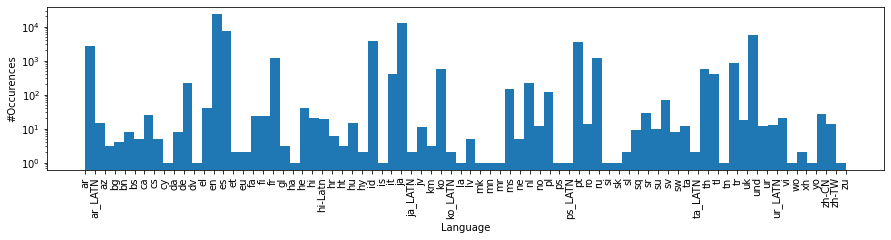

In [ ]:
data_exploration(dataset)

In [ ]:
print_number_of_underrepresented_languages(dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 50 languages in this data set with less then 20 samples.


### 3. Text Cleaning

This is generally a good idea as many text classification tools rely on counting the occurrences of words. If both upper and lower case versions of the same word are found in the text then the algorithm will count them as different words even though the meaning is the same. Of course this does mean that where the capitalised versions of a word exists, that does have a different meaning. For example the company Apple vs the fruit apple. This could result in poorer performance for some data sets. This is one area of NLP where you may try different methods to see how they affect the overall performance of the model.

In [ ]:
def remove_all_emojis(text):
  dem = demoji.findall(text)
  for item in dem.keys():
    text = text.replace(item, '')
  return text

In [ ]:
def clean_data(df, column):
    df = df.copy(deep=True) # Make deep copy of tweets
    df[column] = df[column].str.lower() # Transform into all lowercase
    
    patterns = []
    retweet_pattern = '^RT'
    patterns.append(retweet_pattern)
    xml_pattern = '&\S+;'
    patterns.append(xml_pattern)
    hashtag_pattern = '#[A-Za-z0-9_]+'
    patterns.append(hashtag_pattern)
    twitter_mention_pattern = '@[A-Za-z0-9_]+'
    patterns.append(twitter_mention_pattern)
    http_pattern = 'http\S+'
    patterns.append(http_pattern)
    www_pattern = 'www\S+'
    patterns.append(www_pattern)
    tab_pattern = '\t'
    patterns.append(tab_pattern)
    punctuation_pattern = '[!"#$%&\\()*+,-./:;<=>?@\[\]^_`\'{}~]+'
    patterns.append(punctuation_pattern)
    numeric_pattern = '[0-9]+'
    patterns.append(numeric_pattern)
    regex = "|".join(patterns)

    #df[column] = df[column].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 
    df[column] = df[column].apply(lambda elem: re.sub(r"{}".format(regex), "", elem))
    df[column] = df[column].apply(remove_all_emojis)
    
    return df

In [ ]:
# Now we want to find out which special characters need to be removed from tweets in order to make the prediction better.
# We go over the printed list an not down the symbold which are not needed for language identification.
# These will be removed in a later step.
languages = list(np.unique(test_data['label']))
for language in languages:
  localized_tweets = training_data[training_data['label'] == language]
  # Clean and compare them
  cleaned_localized_tweets = clean_data(localized_tweets, 'tweet')
  comparison_view = pd.concat([localized_tweets.drop(['label'], axis=1), cleaned_localized_tweets], axis=1)
  print(comparison_view.head(5))
  #print(localized_tweets.head(5))
  print("---")

# Symbols like @<mention>, #, http://link !, numeric values (e.g 16000), " do not help for language identification.

                                               tweet                                              tweet label
0  يا من أناديها ويخنقني البكاء  ويكاد صمت الدمع ...  يا من أناديها ويخنقني البكاء  ويكاد صمت الدمع ...    ar
1  فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...  فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...    ar
2  ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...  ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...    ar
3                                  يا ابو سلو عرفتني                                  يا ابو سلو عرفتني    ar
4  ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...  ب ريال أكفل معتمر في رمضان ، ولك بإذن الله مثل...    ar
---
                                         tweet                            tweet    label
2199                      ya allah ya allah x)              ya allah ya allah x  ar_LATN
2200                   Ya rab tekhlas hel game          ya rab tekhlas hel game  ar_LATN
2201                           Istaqfurullah 😂                   ista

In [ ]:
cleaned_dataset = clean_data(dataset, TARGET_COLUMN)

In [ ]:
cleaned_dataset.isnull().values.any() # Dataset does not contain any rows with null values

False

### 4.Data Augmentation

In [ ]:
def back_translation(df,target_languages=['en']):
  translated_data = pd.DataFrame(columns={TWEET_COLUMN, TARGET_COLUMN})
  for target_language in target_languages:
    for index, row in df.iterrows():
      try:
        tweet = row['tweet']
        source_language = row['label']
        translated_data=translated_data.append({'tweet': translator.translate(translator.translate(tweet, dest=target_language).text, dest=source_language).text, 'label': source_language}, ignore_index=True)
      except Exception as e:
        print(e)
        pass
  return translated_data

In [ ]:
print_number_of_underrepresented_languages(cleaned_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 50 languages in this data set with less then 20 samples.


In [ ]:
underrepresented_languages = get_underrepresented_languages(cleaned_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

['arlatn', 'az', 'bg', 'bn', 'bs', 'cs', 'cy', 'da', 'dv', 'et', 'eu', 'gl', 'ha', 'hilatn', 'hr', 'ht', 'hu', 'hy', 'is', 'jalatn', 'jv', 'km', 'kolatn', 'la', 'lv', 'mk', 'mn', 'mr', 'ne', 'no', 'ps', 'pslatn', 'ro', 'si', 'sk', 'sl', 'sq', 'su', 'sw', 'ta', 'talatn', 'tn', 'uk', 'ur', 'urlatn', 'wo', 'xh', 'yo', 'zhtw', 'zu']


In [ ]:
upsampled_dataset = cleaned_dataset.copy()
for l in underrepresented_languages:
  if not l.endswith('latn'): 
    continue #skip latn languages because they dont work with back translation
  underrepresented_language = upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l]
  upsampled_dataset.drop(upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l].index, inplace = True, axis=0)
  len_first = len(underrepresented_language)
  if not l.endswith('latn'): #skip latn languages because they dont work with back translation
    underrepresented_language = pd.concat([underrepresented_language, back_translation(underrepresented_language)], axis=0)
  len_second = len(underrepresented_language)
  if(len_second < SAMPLE_THRESHOLD):
    underrepresented_language = resample(underrepresented_language, n_samples=SAMPLE_THRESHOLD)
  len_third = len(underrepresented_language)
  print("({0}): #{1}=>back_translation=>#{2}=>resampling=>#{3}".format(l, len_first, len_second, len_third))
  upsampled_dataset = pd.concat([upsampled_dataset, underrepresented_language], axis=0)

arlatn
az
(az): #3=>back_translation=>#6=>resampling=>#20
bg
(bg): #4=>back_translation=>#8=>resampling=>#20
bn
(bn): #8=>back_translation=>#16=>resampling=>#20
bs
(bs): #5=>back_translation=>#10=>resampling=>#20
cs
(cs): #5=>back_translation=>#10=>resampling=>#20
cy
(cy): #1=>back_translation=>#2=>resampling=>#20
da
(da): #8=>back_translation=>#16=>resampling=>#20
dv
invalid destination language
(dv): #1=>back_translation=>#1=>resampling=>#20
et
(et): #2=>back_translation=>#4=>resampling=>#20
eu
(eu): #2=>back_translation=>#4=>resampling=>#20
gl
(gl): #3=>back_translation=>#6=>resampling=>#20
ha
(ha): #1=>back_translation=>#2=>resampling=>#20
hilatn
hr
(hr): #6=>back_translation=>#12=>resampling=>#20
ht
(ht): #3=>back_translation=>#6=>resampling=>#20
hu
(hu): #15=>back_translation=>#30=>resampling=>#30
hy
(hy): #2=>back_translation=>#4=>resampling=>#20
is
(is): #1=>back_translation=>#2=>resampling=>#20
jalatn
jv
invalid destination language
invalid destination language
invalid destina

In [ ]:
upsampled_dataset.reset_index(drop=True)

,tweet,label
0,Anyone goin to the rope swing?,en
1,No fue fácil pero valió la pena.,es
2,@jochortega es plaga el lala jajajaja,es
3,特進の校舎のトイレはウォシュレットがついていて羨ましい,ja
4,"두 눈을 감은 이유가, 누구때문도 아니기를...",ko
...,...,...
67637,@Official_SABC1 Moloooo nakuwe!!!,zu
67638,@Official_SABC1 Moloooo nakuwe!!!,zu
67639,@Official_SABC1 Moloooo nakuwe!!!,zu
67640,@Official_SABC1 Moloooo nakuwe!!!,zu


In [ ]:
upsampled_dataset.to_pickle('./dataset.pkl')

In [ ]:
upsampled_dataset.to_csv('./dataset.csv', header=True, index=False)

In [ ]:
get_underrepresented_languages(upsampled_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

[]

In [ ]:
print_number_of_underrepresented_languages(upsampled_dataset, TARGET_COLUMN, SAMPLE_THRESHOLD)

There are 0 languages in this data set with less then 20 samples.


In [ ]:
#for l in underrepresented_languages:
#  underrepresented_language = upsampled_dataset[upsampled_dataset[TARGET_COLUMN]==l]
#  underrepresented_language = resample(underrepresented_language, n_samples=SAMPLE_THRESHOLD)
#  upsampled_dataset = pd.concat([upsampled_dataset, underrepresented_language], axis=0)

In [ ]:
print("The length of the upsampled dataset is {}".format(len(upsampled_dataset)))

The length of the upsampled dataset is 67642


## 2. Data Preparation

In [ ]:
TARGET_COLUMN = 'label'
TWEET_COLUMN = 'tweet'
dataset=upsampled_dataset

In [ ]:
X = dataset[TWEET_COLUMN]
y = dataset[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

In [ ]:
# Vectorize with ngram_range 1 to 3
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
print(type(X_train_vec))

<class 'scipy.sparse.csr.csr_matrix'>


## 3. Model Training

In [ ]:
# All parameters we are individually testing
# If the computational power would be high enough we could
# use GridSearchCV to easily find the best hyperparameters
# However running this grid search CV exceeds colabs max runtime.
parameters = {
        'hidden_layer_sizes': [100, 500],
        'solver': ['adam', 'sgd'],
        'activation': ['tanh', 'relu'],
}


## hidden_layer_sizes=(100): configuration 1-4




### Configuration 01

In [ ]:
mlp_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(100), solver='adam', activation='tanh', max_iter=100, verbose=True)
mlp_clf.fit(X_train_vec, y_train)

Iteration 1, loss = 1.35136123
Validation score: 0.864488
Iteration 2, loss = 0.38750770
Validation score: 0.898160
Iteration 3, loss = 0.20907587
Validation score: 0.912779
Iteration 4, loss = 0.12316765
Validation score: 0.914586
Iteration 5, loss = 0.07781613
Validation score: 0.918857
Iteration 6, loss = 0.05258100
Validation score: 0.919021
Iteration 7, loss = 0.03794585
Validation score: 0.919678
Iteration 8, loss = 0.02905713
Validation score: 0.919021
Iteration 9, loss = 0.02351217
Validation score: 0.918693
Iteration 10, loss = 0.01983701
Validation score: 0.916064
Iteration 11, loss = 0.01737863
Validation score: 0.917050
Iteration 12, loss = 0.01551853
Validation score: 0.917050
Iteration 13, loss = 0.01421724
Validation score: 0.915243
Iteration 14, loss = 0.01312494
Validation score: 0.915079
Iteration 15, loss = 0.01225299
Validation score: 0.914586
Iteration 16, loss = 0.01154947
Validation score: 0.914750
Iteration 17, loss = 0.01087968
Validation score: 0.915900
Iterat

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [ ]:
print(classification_report(y_test, mlp_clf.predict(X_test_vec)))

              precision    recall  f1-score   support

          ar       0.98      0.98      0.98       256
      arlatn       1.00      1.00      1.00         1
          az       1.00      1.00      1.00        10
          bg       1.00      1.00      1.00         2
          bn       1.00      1.00      1.00         5
          bs       1.00      1.00      1.00        11
          ca       0.00      0.00      0.00         4
          cs       1.00      1.00      1.00         4
          cy       1.00      1.00      1.00         3
          da       1.00      1.00      1.00         4
          de       1.00      0.79      0.88        28
          dv       1.00      1.00      1.00         8
          el       1.00      0.80      0.89         5
          en       0.93      0.97      0.95      2357
          es       0.92      0.95      0.93       728
          et       1.00      1.00      1.00         3
          eu       1.00      1.00      1.00         3
          fa       1.00    

### Configuration 02

In [ ]:
mlp_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(100), solver='adam', activation='relu', max_iter=100, verbose=True)
mlp_clf.fit(X_train_vec, y_train)

Iteration 1, loss = 1.44080992
Validation score: 0.869087
Iteration 2, loss = 0.40336973
Validation score: 0.904895
Iteration 3, loss = 0.22184401
Validation score: 0.920828
Iteration 4, loss = 0.13248716
Validation score: 0.926248
Iteration 5, loss = 0.08481837
Validation score: 0.926577
Iteration 6, loss = 0.05784939
Validation score: 0.926413
Iteration 7, loss = 0.04195377
Validation score: 0.926248
Iteration 8, loss = 0.03211862
Validation score: 0.927070
Iteration 9, loss = 0.02582995
Validation score: 0.925756
Iteration 10, loss = 0.02167531
Validation score: 0.924606
Iteration 11, loss = 0.01884304
Validation score: 0.925099
Iteration 12, loss = 0.01690268
Validation score: 0.924770
Iteration 13, loss = 0.01537346
Validation score: 0.924606
Iteration 14, loss = 0.01423894
Validation score: 0.924606
Iteration 15, loss = 0.01328507
Validation score: 0.924934
Iteration 16, loss = 0.01248132
Validation score: 0.924934
Iteration 17, loss = 0.01183086
Validation score: 0.923784
Iterat

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [ ]:
print(classification_report(y_test, mlp_clf.predict(X_test_vec)))

              precision    recall  f1-score   support

          ar       0.98      0.97      0.98       256
      arlatn       1.00      1.00      1.00         1
          az       1.00      1.00      1.00        10
          bg       1.00      1.00      1.00         2
          bn       1.00      1.00      1.00         5
          bs       1.00      1.00      1.00        11
          ca       0.00      0.00      0.00         4
          cs       1.00      1.00      1.00         4
          cy       1.00      1.00      1.00         3
          da       1.00      1.00      1.00         4
          de       1.00      0.82      0.90        28
          dv       1.00      1.00      1.00         8
          el       1.00      0.80      0.89         5
          en       0.93      0.96      0.95      2357
          es       0.92      0.95      0.94       728
          et       1.00      1.00      1.00         3
          eu       1.00      1.00      1.00         3
          fa       1.00    

### Configuration 03

In [ ]:
mlp_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(100), solver='sgd', activation='tanh', max_iter=100, verbose=True)
mlp_clf.fit(X_train_vec, y_train)

Iteration 1, loss = 3.83790675
Validation score: 0.346091
Iteration 2, loss = 2.80005137
Validation score: 0.346091
Iteration 3, loss = 2.43424634
Validation score: 0.346091
Iteration 4, loss = 2.29328226
Validation score: 0.346091
Iteration 5, loss = 2.21992028
Validation score: 0.346091
Iteration 6, loss = 2.16930773
Validation score: 0.366130
Iteration 7, loss = 2.12569797
Validation score: 0.480289
Iteration 8, loss = 2.08346862
Validation score: 0.515769
Iteration 9, loss = 2.04120553
Validation score: 0.526938
Iteration 10, loss = 1.99883010
Validation score: 0.530388
Iteration 11, loss = 1.95691272
Validation score: 0.529074
Iteration 12, loss = 1.91601130
Validation score: 0.528581
Iteration 13, loss = 1.87660695
Validation score: 0.527431
Iteration 14, loss = 1.83893518
Validation score: 0.527102
Iteration 15, loss = 1.80301735
Validation score: 0.527102
Iteration 16, loss = 1.76876771
Validation score: 0.525953
Iteration 17, loss = 1.73596789
Validation score: 0.527267
Iterat

In [ ]:
print(classification_report(y_test, mlp_clf.predict(X_test_vec)))

              precision    recall  f1-score   support

          ar       0.97      0.95      0.96       274
      arlatn       0.00      0.00      0.00         5
          az       0.00      0.00      0.00         5
          bg       0.00      0.00      0.00         3
          bn       0.00      0.00      0.00         2
          bs       0.00      0.00      0.00         5
          ca       0.00      0.00      0.00         3
          cs       0.00      0.00      0.00         5
          cy       0.00      0.00      0.00         5
          da       0.00      0.00      0.00         1
          de       0.00      0.00      0.00        19
          dv       0.00      0.00      0.00         2
          el       0.00      0.00      0.00         1
          en       0.84      0.97      0.90      2355
          es       0.67      0.90      0.77       763
          et       0.00      0.00      0.00         4
          eu       0.00      0.00      0.00         5
          fi       0.00    

### Configuration 04

In [ ]:
mlp_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(100), solver='sgd', activation='relu', max_iter=100, verbose=True)
mlp_clf.fit(X_train_vec, y_train)

Iteration 1, loss = 4.02919301
Validation score: 0.346748
Iteration 2, loss = 3.14377492
Validation score: 0.346748
Iteration 3, loss = 2.56392484
Validation score: 0.346748
Iteration 4, loss = 2.35278089
Validation score: 0.346748
Iteration 5, loss = 2.26528485
Validation score: 0.346748
Iteration 6, loss = 2.21389089
Validation score: 0.346748
Iteration 7, loss = 2.17213758
Validation score: 0.348883
Iteration 8, loss = 2.13207392
Validation score: 0.453515
Iteration 9, loss = 2.09104169
Validation score: 0.498357
Iteration 10, loss = 2.04880234
Validation score: 0.517247
Iteration 11, loss = 2.00590778
Validation score: 0.521189
Iteration 12, loss = 1.96306010
Validation score: 0.520696
Iteration 13, loss = 1.92126695
Validation score: 0.519054
Iteration 14, loss = 1.88095186
Validation score: 0.518397
Iteration 15, loss = 1.84241353
Validation score: 0.518233
Iteration 16, loss = 1.80577731
Validation score: 0.518068
Iteration 17, loss = 1.77081258
Validation score: 0.519218
Iterat

**This code crashed after running for around 5 hours and we were not able to print the classification report. However, since the validation score is just at 78% eprcent after 91 iterations, we will not rerun it since it wont achieve the performance of the models being trained with Adam.**

In [ ]:
classification_report(y_test, mlp_clf.predict(X_test_vec))

<a href="https://colab.research.google.com/github/jan-kreischer/UZH_ML4NLP/blob/main/Project-01/ex01_mlp_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## hidden_layer_sizes=(200): configuration 5-8

### Configuration 5

In [ ]:
mlp_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(200), solver='adam', activation='tanh', max_iter=100, verbose=True)
mlp_clf.fit(X_train_vec, y_train)



Iteration 1, loss = 1.09069852
Validation score: 0.898160
Iteration 2, loss = 0.27471013
Validation score: 0.921321
Iteration 3, loss = 0.13070372
Validation score: 0.925591
Iteration 4, loss = 0.07119369
Validation score: 0.925427
Iteration 5, loss = 0.04386892
Validation score: 0.924277
Iteration 6, loss = 0.03021037
Validation score: 0.921813
Iteration 7, loss = 0.02308790
Validation score: 0.918693
Iteration 8, loss = 0.01875333
Validation score: 0.920171
Iteration 9, loss = 0.01624824
Validation score: 0.920171
Iteration 10, loss = 0.01456572
Validation score: 0.921321
Iteration 11, loss = 0.01326822
Validation score: 0.921156
Iteration 12, loss = 0.01228777
Validation score: 0.920007
Iteration 13, loss = 0.01157770
Validation score: 0.920171
Iteration 14, loss = 0.01090817
Validation score: 0.921156
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=200, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [ ]:
print(classification_report(y_test, mlp_clf.predict(X_test_vec)))

              precision    recall  f1-score   support

          ar       0.99      0.97      0.98       259
      arlatn       0.00      0.00      0.00         3
          az       1.00      1.00      1.00         4
          bg       1.00      1.00      1.00         3
          bn       1.00      1.00      1.00         3
          bs       1.00      1.00      1.00         2
          ca       0.00      0.00      0.00         1
          cs       1.00      1.00      1.00         5
          cy       1.00      1.00      1.00         1
          da       1.00      0.80      0.89         5
          de       1.00      0.54      0.70        24
          dv       1.00      1.00      1.00         7
          el       1.00      0.75      0.86         4
          en       0.92      0.97      0.94      2255
          es       0.94      0.94      0.94       789
          et       1.00      1.00      1.00         4
          eu       1.00      1.00      1.00         2
          fa       1.00    

### Configuration 6

In [ ]:
mlp_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(200), solver='adam', activation='relu', max_iter=100, verbose=True)
mlp_clf.fit(X_train_vec, y_train)


Iteration 1, loss = 1.16928718
Validation score: 0.896846
Iteration 2, loss = 0.27827844
Validation score: 0.924277
Iteration 3, loss = 0.13075589
Validation score: 0.931012
Iteration 4, loss = 0.07191803
Validation score: 0.931012
Iteration 5, loss = 0.04476653
Validation score: 0.931176
Iteration 6, loss = 0.03102889
Validation score: 0.930026
Iteration 7, loss = 0.02358820
Validation score: 0.929041
Iteration 8, loss = 0.01942962
Validation score: 0.929369
Iteration 9, loss = 0.01665520
Validation score: 0.929369
Iteration 10, loss = 0.01488181
Validation score: 0.928384
Iteration 11, loss = 0.01358687
Validation score: 0.928384
Iteration 12, loss = 0.01254886
Validation score: 0.928548
Iteration 13, loss = 0.01174835
Validation score: 0.927727
Iteration 14, loss = 0.01116501
Validation score: 0.928219
Iteration 15, loss = 0.01050550
Validation score: 0.927727
Iteration 16, loss = 0.01003985
Validation score: 0.928384
Validation score did not improve more than tol=0.000100 for 10 co

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=200, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [ ]:
print(classification_report(y_test, mlp_clf.predict(X_test_vec)))

              precision    recall  f1-score   support

          ar       0.98      0.99      0.99       283
      arlatn       1.00      1.00      1.00         4
          az       1.00      1.00      1.00         4
          bg       1.00      1.00      1.00         7
          bn       1.00      1.00      1.00         2
          bs       1.00      0.80      0.89         5
          ca       0.00      0.00      0.00         2
          cs       1.00      1.00      1.00         3
          cy       1.00      1.00      1.00         6
          da       1.00      1.00      1.00         2
          de       1.00      0.78      0.88        37
          dv       1.00      1.00      1.00         3
          el       1.00      1.00      1.00         1
          en       0.93      0.97      0.95      2272
          es       0.93      0.95      0.94       734
          et       1.00      1.00      1.00         3
          eu       1.00      1.00      1.00         7
          fa       1.00    

### Configuration 7

In [ ]:
mlp_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(200), solver='sgd', activation='tanh', max_iter=100, verbose=True)
mlp_clf.fit(X_train_vec, y_train)

Iteration 1, loss = 3.70249981
Validation score: 0.343627
Iteration 2, loss = 2.69717160
Validation score: 0.343627
Iteration 3, loss = 2.39582595
Validation score: 0.343627
Iteration 4, loss = 2.26983137
Validation score: 0.343627
Iteration 5, loss = 2.20258270
Validation score: 0.343627
Iteration 6, loss = 2.15363711
Validation score: 0.386170
Iteration 7, loss = 2.10856486
Validation score: 0.485381
Iteration 8, loss = 2.06354278
Validation score: 0.509198
Iteration 9, loss = 2.01797672
Validation score: 0.521353
Iteration 10, loss = 1.97237272
Validation score: 0.521353
Iteration 11, loss = 1.92752119
Validation score: 0.520368
Iteration 12, loss = 1.88398228
Validation score: 0.518725
Iteration 13, loss = 1.84233862
Validation score: 0.516919
Iteration 14, loss = 1.80273953
Validation score: 0.517083
Iteration 15, loss = 1.76505337
Validation score: 0.517576
Iteration 16, loss = 1.72908061
Validation score: 0.518561
Iteration 17, loss = 1.69467793
Validation score: 0.521353
Iterat

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=200, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [ ]:
print(classification_report(y_test, mlp_clf.predict(X_test_vec)))

              precision    recall  f1-score   support

          ar       0.93      0.96      0.95       255
      arlatn       0.00      0.00      0.00         6
          az       0.00      0.00      0.00         3
          bg       0.00      0.00      0.00         3
          bn       0.00      0.00      0.00         3
          bs       0.00      0.00      0.00         4
          ca       0.00      0.00      0.00         3
          cs       0.00      0.00      0.00         5
          cy       0.00      0.00      0.00         5
          da       0.00      0.00      0.00         3
          de       0.00      0.00      0.00        21
          dv       0.00      0.00      0.00         1
          el       0.00      0.00      0.00         2
          en       0.86      0.96      0.91      2358
          es       0.77      0.92      0.84       738
          et       0.00      0.00      0.00         7
          eu       0.00      0.00      0.00         6
          fa       0.00    

### Configuration 8

In [ ]:
mlp_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(200), solver='sgd', activation='relu', max_iter=100, verbose=True)
mlp_clf.fit(X_train_vec, y_train)

Iteration 1, loss = 3.98300187
Validation score: 0.339520
Iteration 2, loss = 3.03748377
Validation score: 0.339520
Iteration 3, loss = 2.52303243
Validation score: 0.339520
Iteration 4, loss = 2.33395189
Validation score: 0.339520
Iteration 5, loss = 2.23689899
Validation score: 0.339520
Iteration 6, loss = 2.17713531
Validation score: 0.341820
Iteration 7, loss = 2.12898423
Validation score: 0.431012
Iteration 8, loss = 2.08270709
Validation score: 0.502628
Iteration 9, loss = 2.03630077
Validation score: 0.518890
Iteration 10, loss = 1.98986490
Validation score: 0.521189
Iteration 11, loss = 1.94401979
Validation score: 0.521025
Iteration 12, loss = 1.89970961
Validation score: 0.520696
Iteration 13, loss = 1.85725869
Validation score: 0.519547
Iteration 14, loss = 1.81703284
Validation score: 0.519218
Iteration 15, loss = 1.77893385
Validation score: 0.518725
Iteration 16, loss = 1.74274838
Validation score: 0.520204
Iteration 17, loss = 1.70825634
Validation score: 0.522175
Iterat

**The colab session crashed before we get the result after running for 10 hours.**

## hidden_layer_sizes=(500)

### Configuration 9

**We wanted to test the performance of a MLP being trained with adam and relu and one hidden layer with 500 neurons since, adam and relu performed better than sgd and tanh. We could see that the performance is similar to the same model with 100 neurons in the hidden layer.**

In [ ]:
mlp_clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(500), solver='adam', activation='relu', max_iter=50, verbose=True)
mlp_clf.fit(X_train_vec, y_train)

Iteration 1, loss = 0.89183017
Validation score: 0.906866
Iteration 2, loss = 0.17527408
Validation score: 0.919514
Iteration 3, loss = 0.07068142
Validation score: 0.921649
Iteration 4, loss = 0.03743430
Validation score: 0.919842
Iteration 5, loss = 0.02444688
Validation score: 0.915572
Iteration 6, loss = 0.01876033
Validation score: 0.919678
Iteration 7, loss = 0.01559447
Validation score: 0.918528
Iteration 8, loss = 0.01382175
Validation score: 0.917214
Iteration 9, loss = 0.01289217
Validation score: 0.918857
Iteration 10, loss = 0.01175382
Validation score: 0.919842
Iteration 11, loss = 0.01099969
Validation score: 0.920992
Iteration 12, loss = 0.01045910
Validation score: 0.919514
Iteration 13, loss = 0.00997286
Validation score: 0.917378
Iteration 14, loss = 0.00973240
Validation score: 0.921156
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=500, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=50,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [ ]:
print(classification_report(y_test, mlp_clf.predict(X_test_vec)))classification_report(y_test, mlp_clf.predict(X_test_vec))

              precision    recall  f1-score   support

          ar       0.98      0.98      0.98       299
      arlatn       1.00      0.67      0.80         3
          az       1.00      1.00      1.00         6
          bg       1.00      1.00      1.00         4
          bn       1.00      1.00      1.00         5
          bs       1.00      0.80      0.89        10
          ca       0.00      0.00      0.00         2
          cs       1.00      1.00      1.00         6
          cy       1.00      1.00      1.00         1
          da       1.00      0.75      0.86         4
          de       1.00      0.83      0.91        24
          dv       1.00      1.00      1.00         7
          el       1.00      1.00      1.00         4
          en       0.94      0.96      0.95      2298
          es       0.94      0.94      0.94       757
          et       1.00      1.00      1.00         3
          eu       1.00      1.00      1.00         5
          fa       1.00    